# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

C:\Users\Smartjuice\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

C:\Users\Smartjuice\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns:
<ul>
<li> Customer name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p></p>
</div>

In [5]:
#your turn
df_merged = df_offers.merge(df_transactions,how='left',left_on='offer_id',right_on='offer_id')
df_merged.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [6]:
table = pd.pivot_table(df_merged,index='customer_name',columns=['offer_id'],values=['n'],fill_value=0)
table

n                             ...                              
offer_id      1  2  3  4  5  6  7  8  9  10  ... 23 24 25 26 27 28 29 30 31 32
customer_name                                ...                              
Adams          0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  1  1  0  0
Allen          0  0  0  0  0  0  0  0  1  0  ...  0  0  0  0  1  0  0  0  0  0
Anderson       0  0  0  0  0  0  0  0  0  0  ...  0  1  0  1  0  0  0  0  0  0
Bailey         0  0  0  0  0  0  1  0  0  0  ...  0  0  0  0  0  0  0  1  0  0
Baker          0  0  0  0  0  0  1  0  0  1  ...  0  0  0  0  0  0  0  0  1  0
...           .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
Williams       0  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  1  0
Wilson         0  0  0  0  0  0  0  1  0  0  ...  0  0  0  0  0  0  0  1  0  0
Wood           1  0  0  0  0  0  0  0  0  1  ...  0  0  0  0  0  0  0  0  1  0
Wright         0  0  0  1  0  1  0  0  0  0  ...  0  0  0  0  1  0  0  0  0  0
Young          0  0  0  0  0  1  0  0  1  0  ...  0  0  0  0  0  0  0  0  1  1

[100 rows x 32 columns]

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
</ul>
</div>

In [7]:
x_cols = table.values

In [8]:
from sklearn.cluster import KMeans
SS = []
n_points = []
K=[]
for i in range(2,11):
    kmeans = KMeans(n_clusters=i).fit(x_cols)
    SS.append(kmeans.inertia_)
    K.append(i)

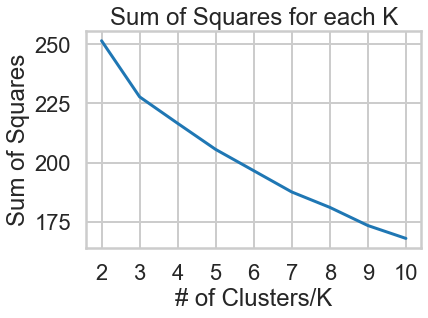

In [9]:
plt.plot(K,SS)
plt.xticks(K)
plt.xlabel('# of Clusters/K')
plt.ylabel('Sum of Squares')
plt.title('Sum of Squares for each K');

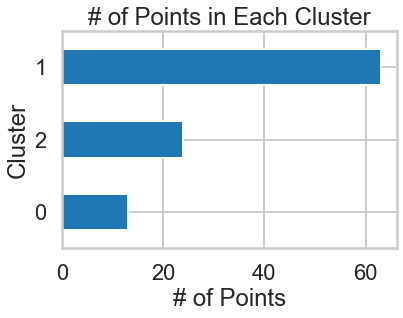

In [10]:
#Best K appears to be 3.
kmeans = KMeans(n_clusters = 3)
labels = kmeans.fit_predict(x_cols)
df = pd.DataFrame({'customer_name':table.index,'labels': labels})
df.labels.value_counts().sort_values().plot(kind = 'barh')
plt.xlabel('# of Points')
plt.ylabel('Cluster')
plt.title('# of Points in Each Cluster');

#### 3aiii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>


<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.1107183912025193
For n_clusters = 4 The average silhouette_score is : 0.12349204708263416
For n_clusters = 5 The average silhouette_score is : 0.11482891379977885
For n_clusters = 6 The average silhouette_score is : 0.11879508142787866
For n_clusters = 7 The average silhouette_score is : 0.10874624428071616
For n_clusters = 8 The average silhouette_score is : 0.14097216560635834
For n_clusters = 9 The average silhouette_score is : 0.14178613108021745
For n_clusters = 10 The average silhouette_score is : 0.12819851045484193


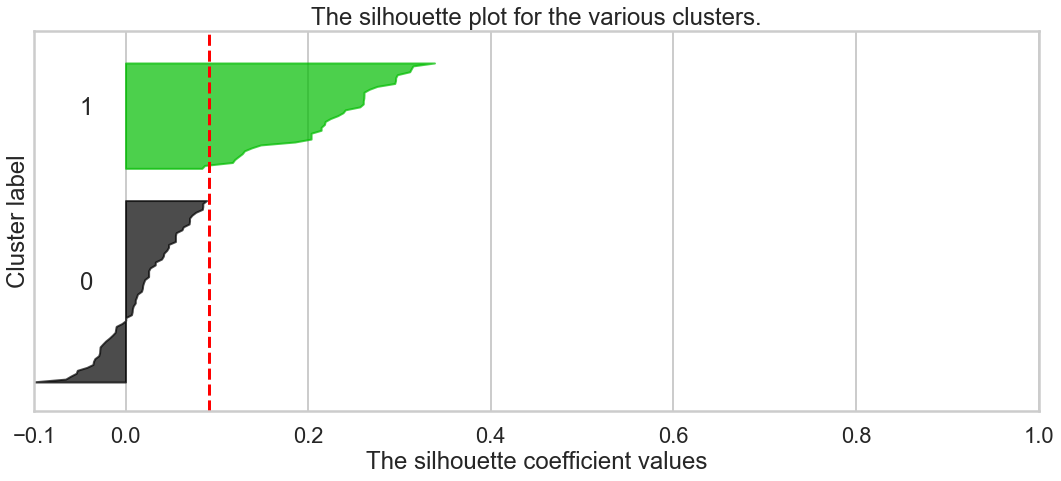

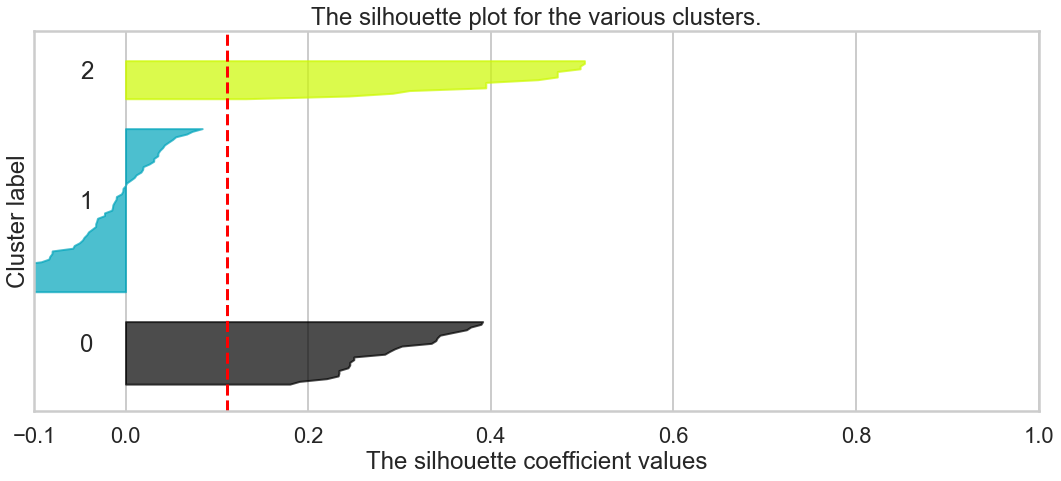

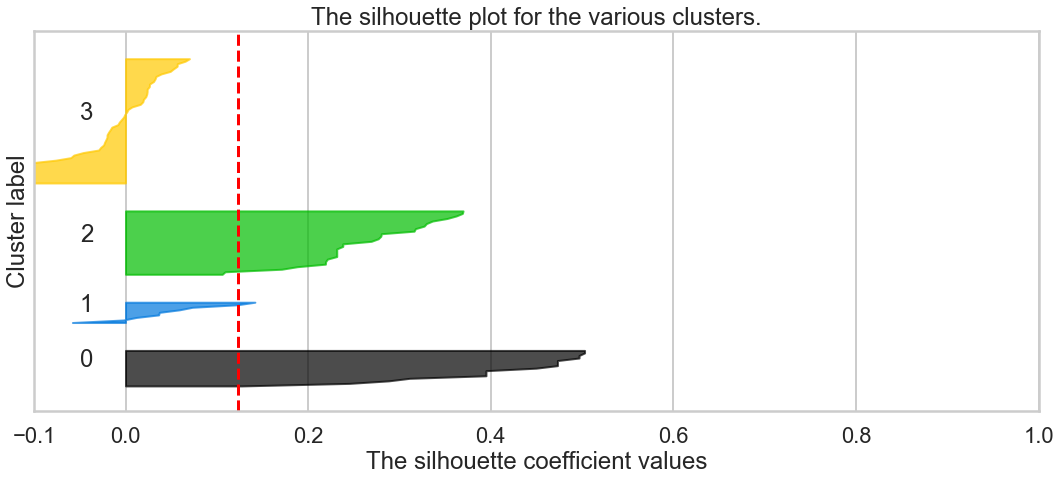

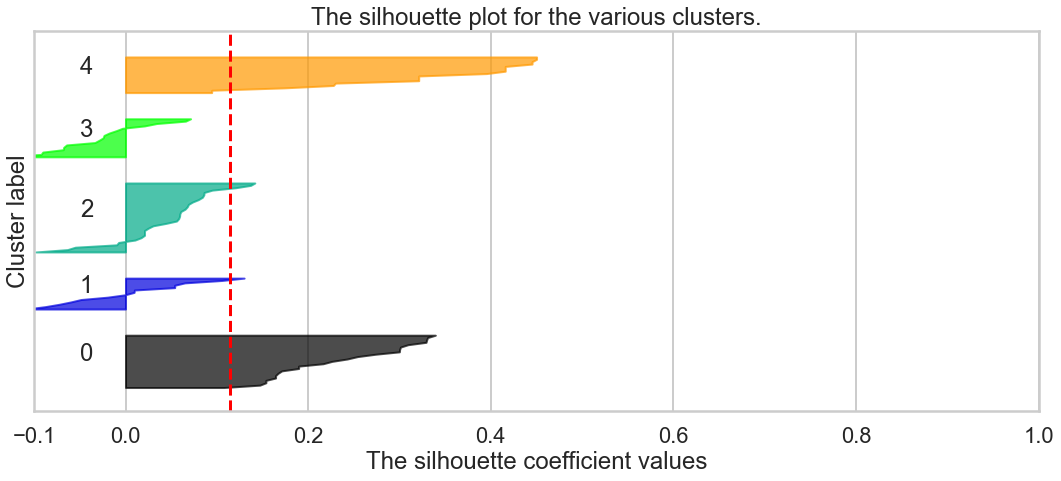

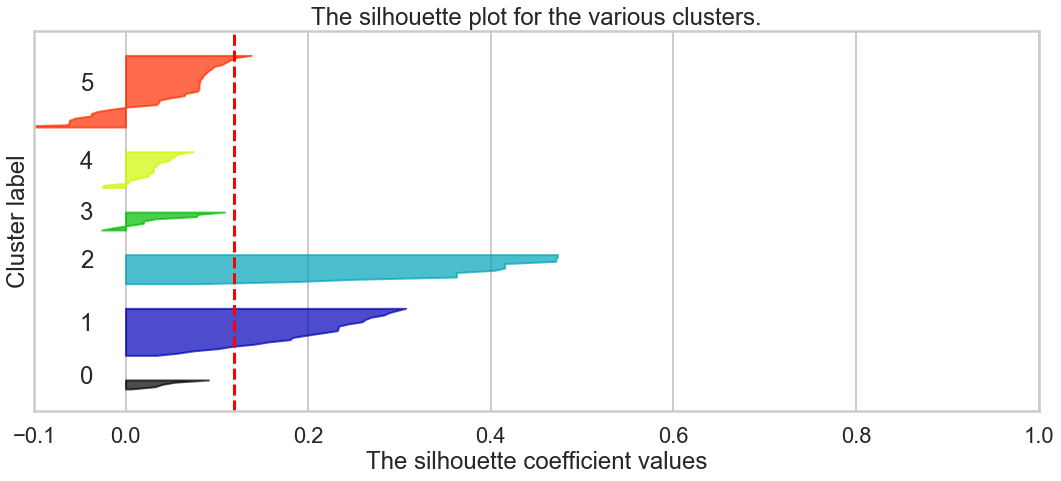

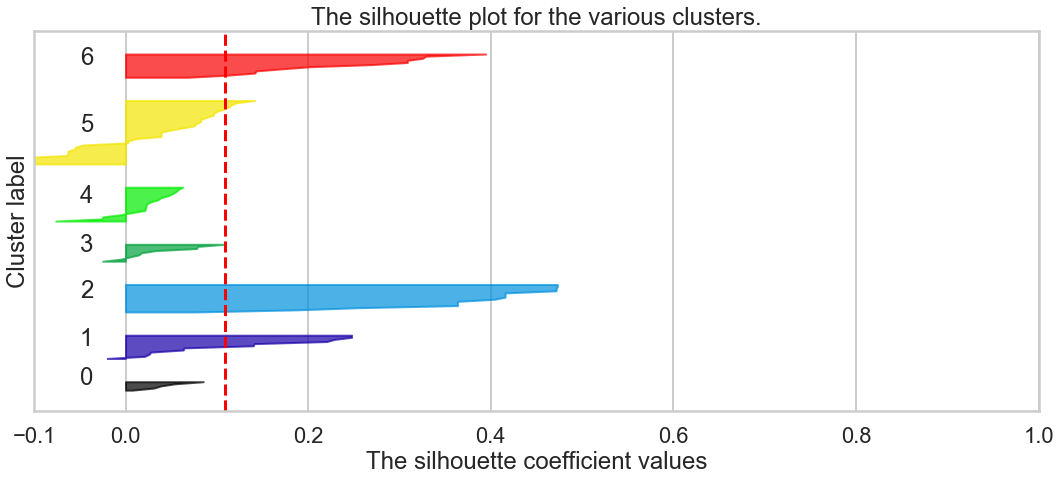

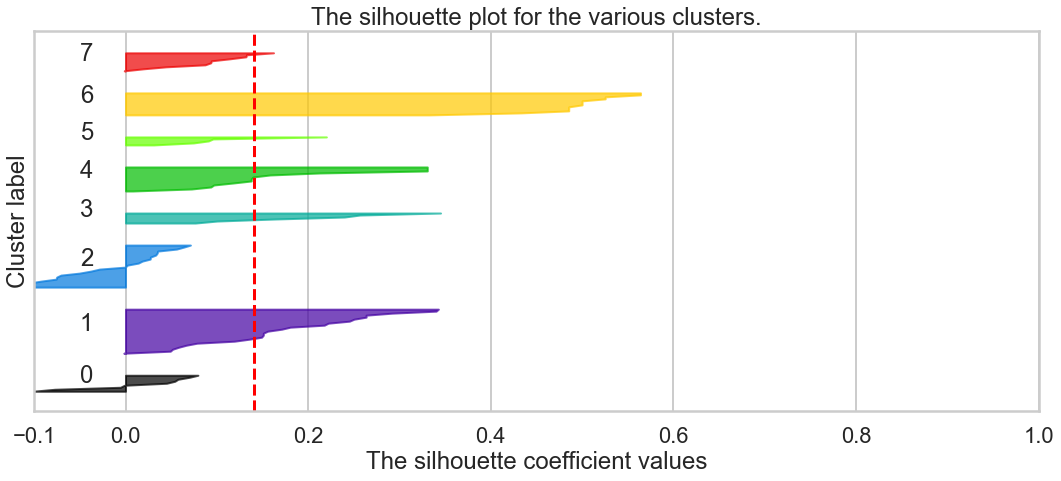

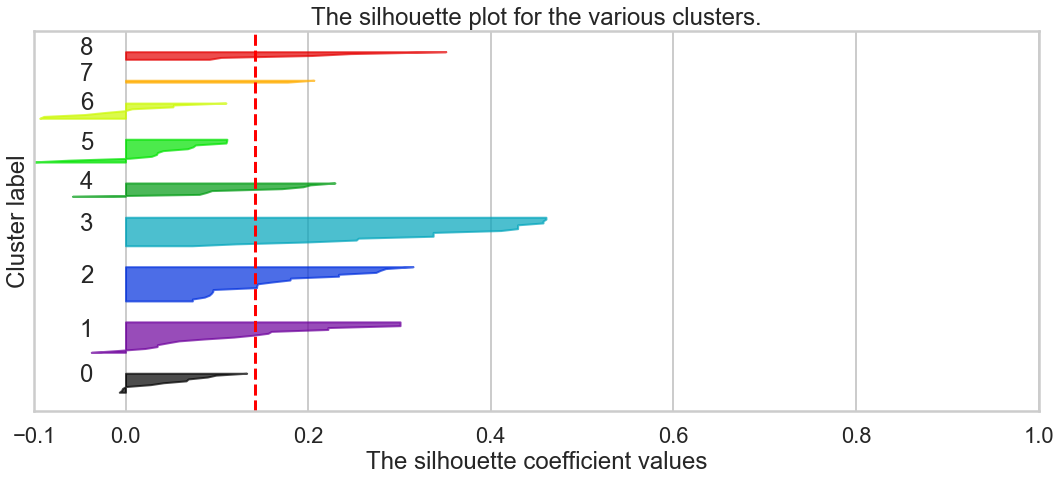

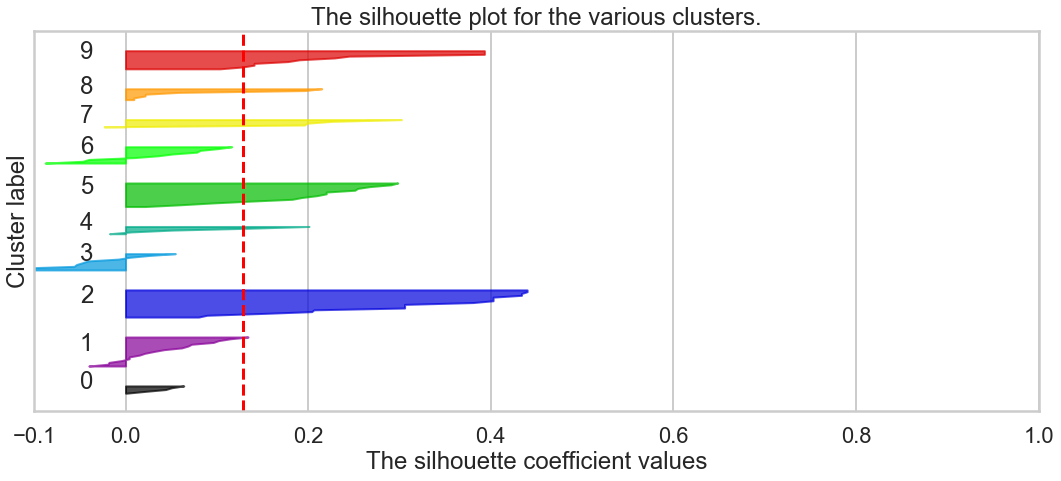

In [11]:
# Your turn.
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm
import numpy as np
sil_scores = []
for i in range(2,11):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_cols) + (i + 1) * 10])
    clusterer = KMeans(n_clusters=i,random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    sil_scores.append(silhouette_avg)
    print(
        "For n_clusters =",
        i,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)
    y_lower = 10
    for j in range(i):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]

        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / i)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

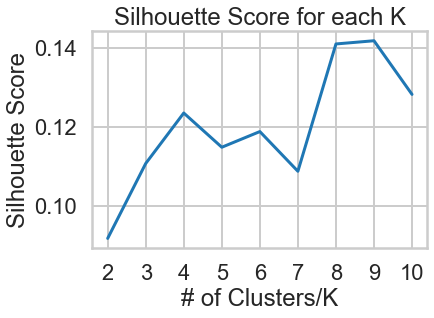

In [12]:
plt.plot(K,sil_scores)
plt.xticks(K)
plt.xlabel('# of Clusters/K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for each K');

This method suggests that 9 clusters is the best instead of 3 like the elbow method does!

#### 3aiv.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

C:\Users\Smartjuice\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


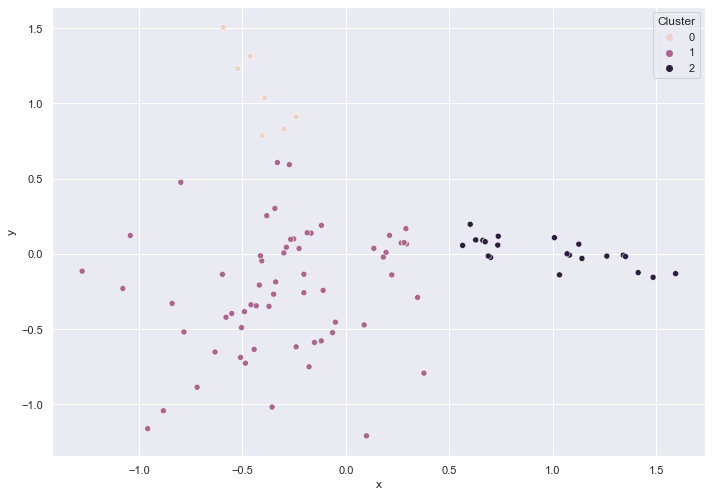

In [13]:
#your turn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(x_cols)
df_pca = pd.DataFrame({'Customer Name':table.index,'Cluster':labels,'x':pca_features[:,0],'y':pca_features[:,1]})
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(df_pca['x'],df_pca['y'],hue=df_pca['Cluster']);

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

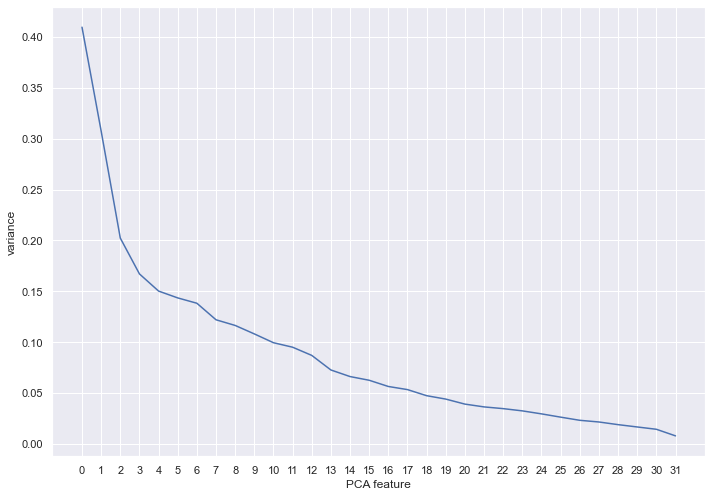

In [14]:
pca = PCA()
pca.fit(x_cols)
features = range(pca.n_components_)
plt.plot(features,pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

Looks like 2 features is optimal!

## 4. Conclusions and next steps

#### 4a. Defining Cluster Profiles

Now that K-Means has given us some Cluster ID's to work with. Let's map these labels back to the data and try to make some observations about some of the unique characteristics in each cluster. We'll use the 3 clusters as determined by our elbow method.

In [15]:
df.set_index('customer_name',inplace=True)

In [16]:
df_merged['cluster_id_pred'] = 0
for i in range(len(df_merged)):
    df_merged['cluster_id_pred'][i] = df.loc[df_merged['customer_name'][i]]['labels']
df_merged.drop(columns='n',inplace=True)

C:\Users\Smartjuice\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
df_merged.describe()

,offer_id,min_qty,discount,cluster_id_pred
count,324.000000,324.000000,324.000000,324.000000
mean,17.012346,58.407407,59.481481,1.117284
std,9.703332,49.741444,20.327877,0.555143
min,1.000000,6.000000,17.000000,0.000000
25%,8.000000,6.000000,45.000000,1.000000
50%,18.000000,72.000000,56.000000,1.000000
75%,26.000000,72.000000,83.000000,1.000000
max,32.000000,144.000000,89.000000,2.000000


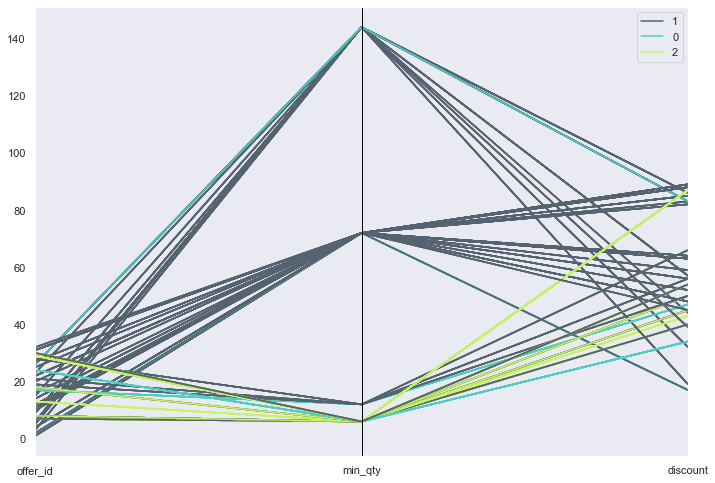

In [18]:
# Display parallel coordinates plots, one for each cluster
pd.plotting.parallel_coordinates(df_merged,'cluster_id_pred',cols=['offer_id','min_qty','discount'],color=('#556270', '#4ECDC4', '#C7F464'))
plt.show();

In [19]:
df_merged.groupby('cluster_id_pred')['varietal'].value_counts()

cluster_id_pred  varietal          
0                Pinot Noir            33
1                Champagne             81
                 Cabernet Sauvignon    32
                 Prosecco              31
                 Espumante             18
                 Malbec                16
                 Chardonnay            15
                 Merlot                14
                 Pinot Noir            11
                 Pinot Grigio           2
2                Espumante             22
                 Malbec                16
                 Pinot Grigio          15
                 Prosecco              12
                 Merlot                 6
Name: varietal, dtype: int64

Interesting - it looks like a defining feature of Cluster 0 is that it is basically the "Pinot Noir" cluster. 37/43 (86%) of Cluster 0's points are Pinot Noir purchases and there are only 7 Pinot Noir points which are NOT in Cluster 2. Let's see if we can interpret anything from these 7 outliers.

In [20]:
df_merged[df_merged.varietal=='Pinot Noir'].sort_values('cluster_id_pred')

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,cluster_id_pred
10,2,January,Pinot Noir,72,17,France,False,Smith,0
221,24,September,Pinot Noir,6,34,Italy,False,Phillips,0
222,24,September,Pinot Noir,6,34,Italy,False,Flores,0
223,24,September,Pinot Noir,6,34,Italy,False,Morris,0
224,24,September,Pinot Noir,6,34,Italy,False,Cook,0
225,24,September,Pinot Noir,6,34,Italy,False,Bell,0
226,24,September,Pinot Noir,6,34,Italy,False,Cox,0
227,24,September,Pinot Noir,6,34,Italy,False,Jenkins,0
234,26,October,Pinot Noir,144,83,Australia,False,Johnson,0
235,26,October,Pinot Noir,144,83,Australia,False,Rodriguez,0


In [21]:
with pd.option_context("display.max_rows", 1000):
    print(df_merged.groupby('customer_name').count().sort_values('min_qty',ascending=False))

               offer_id  campaign  varietal  min_qty  discount  origin  \
customer_name                                                            
Sanders               9         9         9        9         9       9   
Miller                7         7         7        7         7       7   
Sanchez               7         7         7        7         7       7   
Fisher                7         7         7        7         7       7   
Thomas                6         6         6        6         6       6   
Morales               6         6         6        6         6       6   
Harris                6         6         6        6         6       6   
Peterson              6         6         6        6         6       6   
Rogers                6         6         6        6         6       6   
Young                 6         6         6        6         6       6   
Butler                5         5         5        5         5       5   
Lee                   5         5     

It looks like most of the outliers who purchased Pinot Noir but were still categorized in Cluster 1 instead of 0 seem to all be big purchasers. Perhaps this characteristic had a stronger influence in clustering them over being Pinot Noir buyers. Let's investigate Cluster 1 some more to find out.

In [22]:
total_orders = []
df_merged['total_orders'] = 0
for i in range(len(df_merged)):
    df_merged['total_orders'][i] = df_merged.groupby('customer_name').count().loc[df_merged['customer_name'][i]]['offer_id']
df_merged.groupby('cluster_id_pred').total_orders.describe()

C:\Users\Smartjuice\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,count,mean,std,min,25%,50%,75%,max
cluster_id_pred,,,,,,,,
0,33.0,2.757576,0.830298,2.0,2.0,3.0,3.0,4.0
1,220.0,4.454545,1.865996,1.0,3.0,4.0,6.0,9.0
2,71.0,3.309859,1.063573,2.0,2.0,3.0,4.0,5.0


Indeed - Cluster 1 has a significantly larger average "total orders" per customer.

What about Cluster 2? Logically we could assume that Cluster 2 can be characterized as neither belonging to Clusters 0 or 1. In other words, Cluster 2 includes the less frequent customers who order everything that is NOT Pinot Noir. Is there anything else?

In [30]:
df_merged[df_merged.cluster_id_pred==2].min_qty.value_counts()

6    71
Name: min_qty, dtype: int64

In [34]:
df_merged[df_merged.min_qty==6].groupby('cluster_id_pred').describe()

offer_id                                                      \
                   count       mean        std   min   25%   50%   75%   max   
cluster_id_pred                                                                
0                   12.0  24.000000   0.000000  24.0  24.0  24.0  24.0  24.0   
1                   27.0  15.296296  10.106414   7.0   7.5   8.0  29.0  30.0   
2                   71.0  19.197183   9.797404   7.0   8.0  18.0  29.0  30.0   

                min_qty       ... discount       total_orders            \
                  count mean  ...      75%   max        count      mean   
cluster_id_pred               ...                                         
0                  12.0  6.0  ...     34.0  34.0         12.0  2.583333   
1                  27.0  6.0  ...     54.0  87.0         27.0  3.666667   
2                  71.0  6.0  ...     54.0  87.0         71.0  3.309859   

                                                    
                      std  min  25%  50%  75%  max  
cluster_id_pred                                     
0                0.792961  2.0  2.0  2.0  3.0  4.0  
1                1.818706  1.0  2.0  4.0  5.0  7.0  
2                1.063573  2.0  2.0  3.0  4.0  5.0  

[3 rows x 32 columns]

Interesting. It looks like the unifying attribute amongst all of Cluster 2's datapoints is that they are all orders which have a minimum quantity requirement of 6 (although not EVERY order which has a minimum quantity of 6 is necessarily in Cluster 2).

### Cluster Profile Summaries

### Cluster 0: The Pinot Noir Cluster.
This attribute overlaps with Cluster 1 if the Pinot Noir purchaser is a frequent customer in which case the latter characteristic is the stronger determining one.

### Cluster 1: The "Repeat Customer" Cluster. 
This cluster has the largest average "total orders" per customer which  means these are the most loyal customers in our dataset.

### Cluster 2: The "Small Order" Cluster. 
All datapoints in this cluster are orders which have a minimum quantity of 6.

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


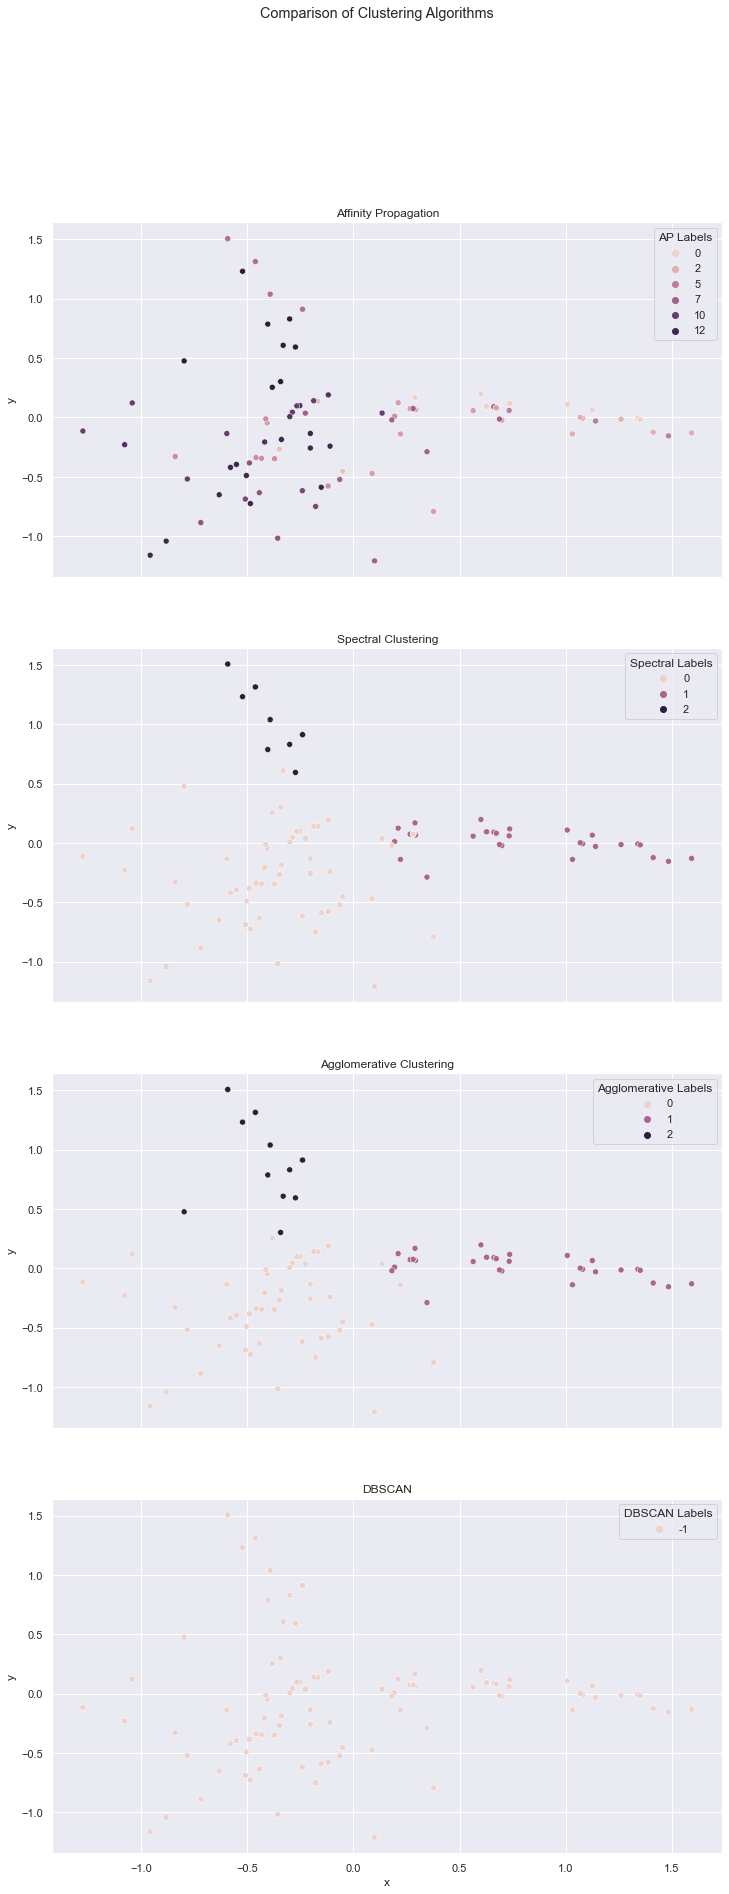

In [23]:
# Affinity Propagation
from sklearn.cluster import AffinityPropagation
ap_clustering_labels = AffinityPropagation().fit_predict(x_cols)

#Spectral Clustering
from sklearn.cluster import SpectralClustering
spec_clustering_labels = SpectralClustering(n_clusters=3).fit_predict(x_cols)

#Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
agglom_clustering_labels = AgglomerativeClustering(n_clusters=3).fit_predict(x_cols)

#DBSCAN
from sklearn.cluster import DBSCAN
DBSCAN_clustering_labels = DBSCAN().fit_predict(x_cols)

#Plot All Algorithms Against Each Other
df_pca_2 = pd.DataFrame({'Customer Name':table.index,'AP Labels':ap_clustering_labels,
                      'Spectral Labels':spec_clustering_labels,'Agglomerative Labels':agglom_clustering_labels,
                      'DBSCAN Labels':DBSCAN_clustering_labels,'x':pca_features[:,0],'y':pca_features[:,1]})
fig, axes = plt.subplots(4,1, sharex=True, sharey=True, figsize=(12,30))
fig.suptitle('Comparison of Clustering Algorithms')
axes[0].set_title('Affinity Propagation')
sns.scatterplot(ax=axes[0], x=df_pca_2['x'], y=df_pca_2['y'], hue=df_pca_2['AP Labels'])
axes[1].set_title('Spectral Clustering')
sns.scatterplot(ax=axes[1], x=df_pca_2['x'], y=df_pca_2['y'], hue=df_pca_2['Spectral Labels']);
axes[2].set_title('Agglomerative Clustering')
sns.scatterplot(ax=axes[2], x=df_pca_2['x'], y=df_pca_2['y'], hue=df_pca_2['Agglomerative Labels']);
axes[3].set_title('DBSCAN')
sns.scatterplot(ax=axes[3], x=df_pca_2['x'], y=df_pca_2['y'], hue=df_pca_2['DBSCAN Labels']);
